# Kalman Filter

#### 1. Robot moves on a 2D plane at constant speed maintaining a constant angle with the x-axis. It reaches the endpoint after 16 seconds.

because of the non-linear relation of the speed magnitude v with the its component, we will assume the following:
$\dot{x}=v\cos(\theta)$ and $\dot{y}=v\sin(\theta)$ as derived from the speed sensor reading. Here $\theta = -30^{\circ}$. Hence $z_k = \frac{1}{\sin(\theta)} \begin{bmatrix} 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y} \end{bmatrix} + v_k$, where $v_k$ represents the sensor error vector.  

a. We assume:
the state vector:
$X=\begin{bmatrix}
    x \\ y \\ \dot{x} \\ \dot{y} 
    \end{bmatrix}$, 
the state transition matrix:
$A=\begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$

The measurement matrix:
$H = \begin{bmatrix} 
0 & 0 & 0 & \frac{1}{\sin(\theta)} \\
\end{bmatrix}
$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_result(true_traj, filtered_states, title):
    plt.plot(true_traj[:, 0], true_traj[:, 1], label='True States', marker='o', markersize=5)

    plt.plot(filtered_states[:, 0], filtered_states[:,1], label='Filtered States', linestyle='--', marker='^', markersize=5)
    plt.suptitle(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [3]:
theta = -np.pi/6 # 30 degrees
v_true = 0.5 # 0.5 m/s
dt = 0.1 # 0.1 s simulation and measurement time step


In [4]:
true_state = np.array([-1,0,v_true*np.cos(theta),v_true*np.sin(theta)]).T
true_state

array([-1.       ,  0.       ,  0.4330127, -0.25     ])

In [5]:
A = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
H = np.array([[0, 0, 0, 1/(np.sin(theta))]])

In [6]:
def kalman_filter_2d(initial_state, initial_covariance, process_noise, measurement_noise, A, H, measurements):
    # Kalman Filter Initialization
    state = initial_state
    covariance = initial_covariance



    # Kalman Filter Parameters
    Q = np.array([[process_noise, 0, 0, 0],
                  [0, process_noise, 0, 0],
                  [0, 0, process_noise, 0],
                  [0, 0, 0, process_noise]])

    R = np.array([measurement_noise])

    # Lists to store results for plotting
    filtered_states = [initial_state[:2]]
    filtered_covariances = []

    # Kalman Filter Loop
    for measurement in measurements:
        # Prediction Step
        state_predict = np.dot(A, state)
        covariance_predict = np.dot(np.dot(A, covariance), A.T) + Q

        # Correction Step
        kalman_gain = np.dot(np.dot(covariance_predict, H.T), np.linalg.pinv(np.dot(np.dot(H, covariance_predict), H.T) + R))
        state = state_predict + np.dot(kalman_gain, (measurement - np.dot(H, state_predict)))
        covariance = covariance_predict - np.dot(np.dot(kalman_gain, H), covariance_predict)

        # Save filtered state and covariance for plotting
        filtered_states.append(state[:2])
        filtered_covariances.append(covariance[:2, :2])

    return filtered_states, filtered_covariances

In [7]:


t_max = 16 # 16 s simulation
# v_k = 0.1 # measurement noise
initial_covariance = np.eye(A.shape[0])
initial_state = np.array([7, -5, v_true*np.cos(theta), v_true*np.sin(theta)]).T

# measurements
# true trajectory
true_trajectory = [true_state[:2]]
for _ in range(int(t_max/dt)):
    true_state = np.dot(A, true_state)
    true_trajectory.append(true_state[:2])

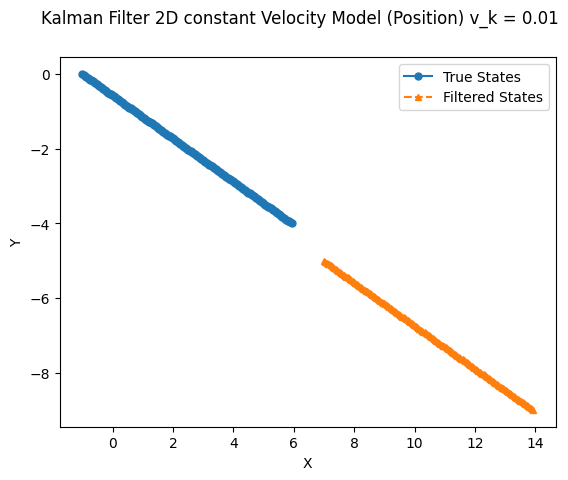

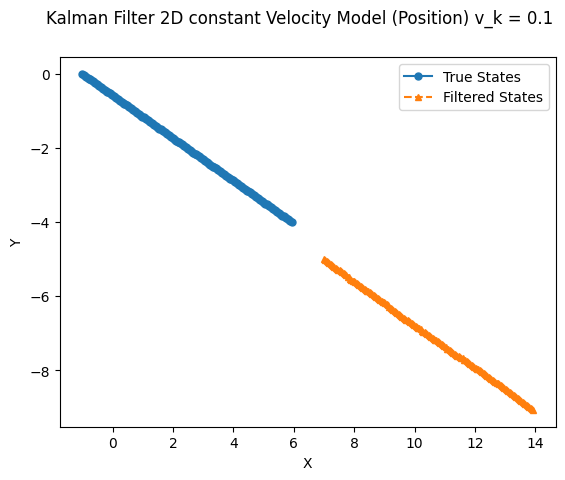

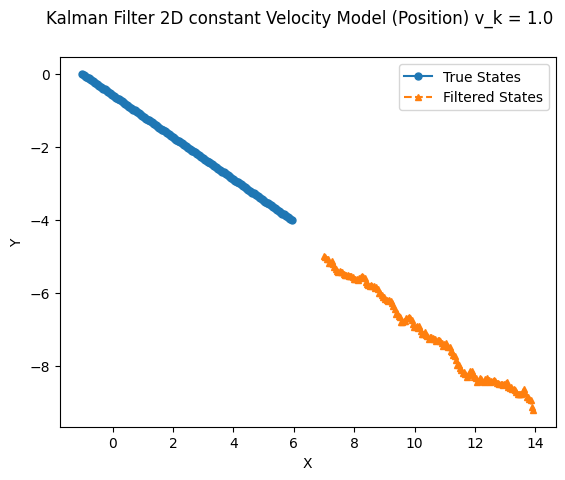

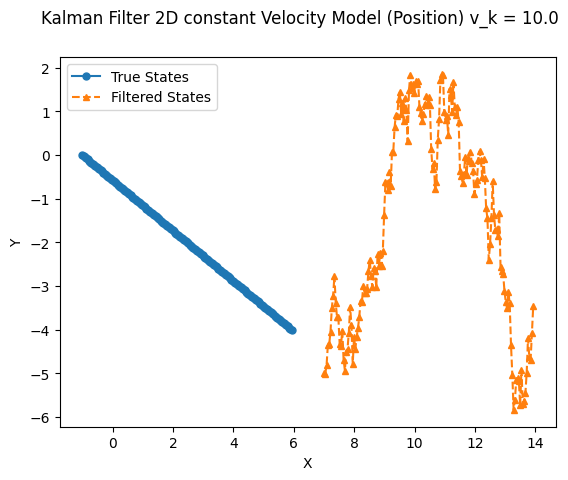

In [8]:
seed = 42
np.random.seed(seed)
for v_k in [0.01, 0.1, 1.0, 10.0]:
        measurements = [
        v_true + np.random.normal(0, 1*v_k) for _ in range(int(t_max/dt))]
        filtered_states, filtered_covariance = kalman_filter_2d(
                initial_state=initial_state,
                initial_covariance=initial_covariance,
                process_noise=0.0,
                measurement_noise=v_k,
                A=A,
                H=H,
                measurements=measurements)
        # print(filtered_states)
        filtered_states = np.asarray(filtered_states)
        true_trajectory = np.asarray(true_trajectory)

        plot_result(true_trajectory, filtered_states,
                'Kalman Filter 2D constant Velocity Model (Position) v_k = {}'.format(v_k))

In [ ]:

filtered_states.shape, true_trajectory.shape

In [ ]:
# plt.subplot(1, 2, 1)


#### b. sensor measures the angle $\theta$
with state $X = \begin{bmatrix} x\\y\\ \theta \end{bmatrix}$
$\theta=\arctan(y/x)$

We are going to use EKF the Extended Kalman Filter in this case.

$x_k = x_{k-1} + V\cos(\theta)\Delta t$

$y_k = x_{k-1} + V\sin(\theta)\Delta t$

$\theta_k = \theta_{k-1} + w\Delta t$ 


$A = \frac{\delta f_i}{\delta x_j} = 
    \begin{bmatrix}
    1 & 0 & -V\sin(\theta)\Delta t \\
    0 & 1 & V\cos(\theta)\Delta t \\
    0 & 0 & 1
    \end{bmatrix}
$

$ W = \frac{\delta f_i}{\delta w_j} = 
    \begin{bmatrix}
        \cos(\theta)\Delta t & 0 \\
        \sin(\theta)\Delta t & 0 \\
        0 & \Delta t 
    \end{bmatrix}
$

$ z_k = h(X) = \arctan(\frac{y}{x}) + v_k
\Rightarrow  H = \frac{\delta h_i}{\delta x_j}=\begin{bmatrix} \frac{-y}{x^2+y^2} & \frac{x}{x^2+y^2} & 0 \end{bmatrix} \ and \ V = \frac{\delta h_i}{\delta v_j} = 1 $ 

In [9]:
def state_transition(state, dt):
    x, y, theta = state[0], state[1], state[2]
    x_p = x + v_true*np.cos(theta)*dt
    y_p = y + v_true*np.sin(theta)*dt
    return np.array([x_p, y_p, theta])

def observation_function(state):
    x, y, theta = state[0], state[1], state[2]
    z = np.arctan2(y, x)
    return z

def ekf_predict(state, covariance, dt, v):
    # assume process noise is 0
    theta = state[2]
    st = np.sin(theta)
    ct = np.cos(theta)
    process_noise = 0
    A = np.array([[1, 0, -v*dt*st],[0, 1, v*dt*ct],[0, 0, 1]], dtype=np.float32)

    Q = process_noise * np.eye(2)
    W = np.array([[v*ct*dt, 0],
                  [v*st*dt, 0],
                  [0, dt]])
    # project the state forward
    state_predict = state_transition(state, dt)
    # project the state estimate error covariance forward
    covariance_predict = A @ covariance @ A.T + W @ Q @ W.T
    return state_predict, covariance_predict

def ekf_correct(state_predict, covariance_predict, measurement, v_k):
    x, y = state_predict[0], state_predict[1]
    # H, V and R:
    H = np.array([[
        -y/(x**2 + y**2),
        x/(x**2 + y**2),
        0
    ]])
    V = np.array([[1]])
    R = np.array([[v_k**2]])

    # compute the Kalman gain
    k_k = covariance_predict @ H.T @ np.linalg.pinv(H @ covariance_predict @ H.T + V @ R @ V.T)
    # print(">> K_k", k_k)


    # update state estimate with measurement z_k
    state_update = state_predict.reshape(-1,1) + k_k @ np.array(measurement - observation_function(state_predict)).reshape(-1,1)

    # update the error covariance:
    covariance_update = covariance_predict - k_k @ H @ covariance_predict
    # print(">> P_k",covariance_update)

    return state_update.flatten(), covariance_update


In [10]:
def ekf_filter(initial_state, initial_covariance, measurement_noise, measurements, dt, speed):
    # Kalman Filter Initialization
    state = initial_state
    covariance = initial_covariance

    # Lists to store results for plotting
    filtered_states = [initial_state[:2]]
    filtered_covariances = []

    # Kalman Filter Loop
    for measurement in measurements:
        # Prediction Step
        state_predict, covariance_predict = ekf_predict(state, covariance, dt, speed)

        # Correction Step
        state, covariance = ekf_correct(state_predict, covariance_predict, measurement, measurement_noise)
        # print(">> state", state)

        # Save filtered state and covariance for plotting
        filtered_states.append(state[:2])
        filtered_covariances.append(covariance[:2, :2])

    return filtered_states, filtered_covariances

In [11]:
initial_state = np.array([-1,0,theta])

initial_covariance = np.eye(3)
# v_k = 0.1
dt = 0.1
t_max = 16
v_true = 0.5
theta_true = -np.pi/6


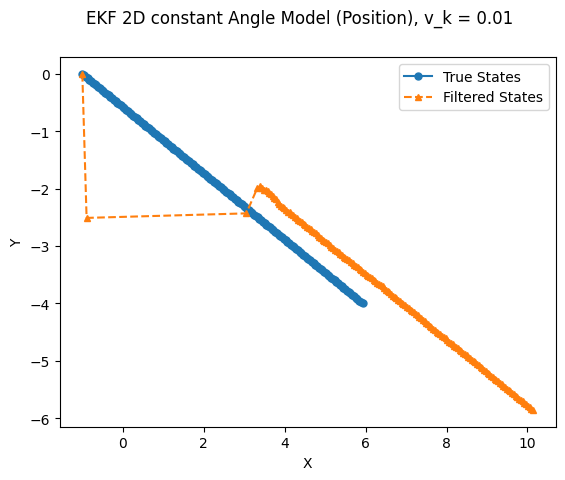

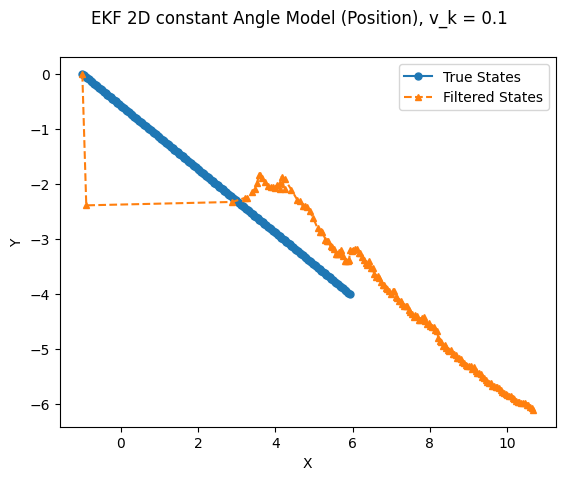

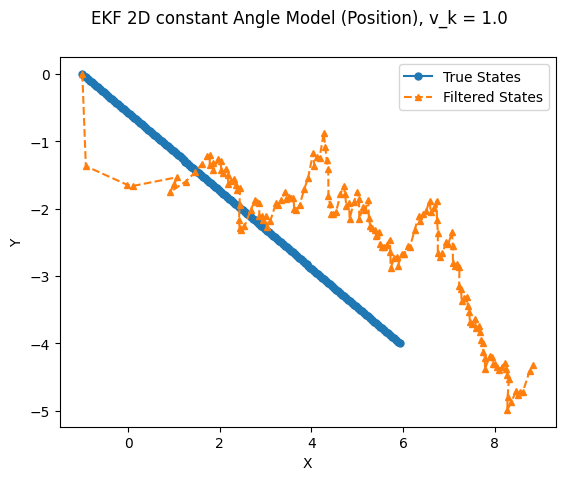

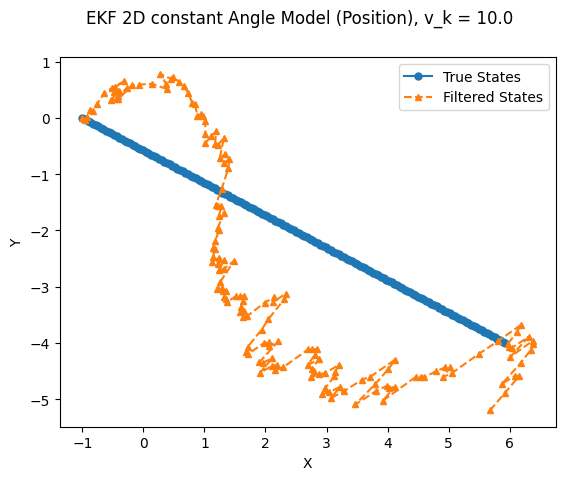

In [12]:
np.random.seed(42)
for v_k in [0.01, 0.1, 1.0, 10.0]:
    measurements = [theta_true +
                    np.random.normal(0, 1*v_k) for _ in range(int(t_max/dt))]
    filtered_states, filtered_covariance = ekf_filter(
        initial_state=initial_state,
        initial_covariance=initial_covariance,
        measurement_noise=v_k,
        measurements=measurements,
        dt=dt,
        speed=v_true)

    filtered_states = np.array(filtered_states)
    plot_result(np.array(true_trajectory), filtered_states,
                'EKF 2D constant Angle Model (Position), v_k = {}'.format(v_k))

#### c. An ultrasonic distance sensor is installed on the robot.
It emits ultra-sonic waves towards a wall located at y=3 during its movement. 
The time between emission and reception is dt=0.1 seconds

<!-- given the state $ X = \begin{bmatrix} x \\ y \\ \theta \\ \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix}$

$x_k = x_{k-1} + \dot{x}_{k-1} \Delta t$

$y_k = x_{k-1} + \dot{y}_{k-1}\Delta t$

$\theta_k = \theta_{k-1} + \dot{\theta}_{k-1}\Delta t$

$\dot{x}_k =  \dot{x}_{k-1}$

$\dot{y}_k = \dot{y}_{k-1}$

$\dot{\theta}_k = \dot{\theta}_{k-1}$

Then 
$A =
\begin{bmatrix} 
    1 & 0 & 0 & \Delta t & 0 & 0 \\
    0 & 1 & 0 & 0 & \Delta t & 0 \\
    0 & 0 & 1 & 0 & 0 & \Delta t \\
    0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}$ -->

$d_{y=3} = |y - 3| + v_k = \sqrt{(y-3)^2} + v_{d_k}
\rightarrow H_d = \frac{\delta h_d}{\delta x_j} = \begin{bmatrix} 0 & \frac{y-3}{|y-3|} & 0  \end{bmatrix}$

$R_d = \begin{bmatrix} \sigma_d^2 \end{bmatrix} \ and \ V_d=\frac{\delta h_d}{\delta v_i}= 1$

<!-- $v = f( \dot{x}, \dot{y}) = \frac{1}{\sin(\theta)} (\dot{y}) + v_{v_k} 
\rightarrow H_v = \frac{\delta h_v}{\delta x_j} =  
\begin{bmatrix}
    0 & 0 & \frac{-\dot{y}cos(\theta)}{\sin^2(\theta)} & 0 &  \frac{1}{\sin(\theta)} & 0
\end{bmatrix} 
$

$R_v = \begin{bmatrix} {v_{speed}}^2 \end{bmatrix} \ and \ V_v=\frac{\delta h_v}{\delta v_{v_k}}= 1$



$\tilde{\theta} = h_{\theta}(X) = \arctan(\frac{y}{x}) + \dot{\theta} \Delta t + v_{\theta_k}
\Rightarrow  H_{\theta} = \frac{\delta h_i}{\delta x_j}=\begin{bmatrix} \frac{-y}{x^2+y^2} & \frac{x}{x^2+y^2} & 0 & 0 & 0 & \Delta t \end{bmatrix} \ and \ V_{\theta} = \frac{\delta h_i}{\delta v_j} = 1$
 -->
<!-- 
$H = 
\begin{bmatrix} 
    H_d \\
    H_v \\
    H_{\theta}
\end{bmatrix} = 
 \begin{bmatrix} 
    0 & \frac{y-3}{|y-3|} & 0 & 0 & 0 & 0 \\
    0 & 0 & \frac{-\dot{y}cos(\theta)}{\sin^2(\theta)} & 0 &  \frac{1}{\sin(\theta)} & 0 \\
    \frac{-y}{x^2+y^2} & \frac{x}{x^2+y^2} & 0 & 0 & 0 & \Delta t
\end{bmatrix} 
$

$R = 
\begin{bmatrix} 
    R_d & 0 & 0 \\
    0 & R_{speed} & 0 \\
    0 & 0 & R_{\theta}
\end{bmatrix}
$

$V = 
\begin{bmatrix} 
    V_d & 0 & 0 \\
    0 & V_{speed} & 0 \\
    0 & 0 & V_{\theta}
\end{bmatrix}
$ -->
<!-- \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y} \\ \theta \\ \dot{\theta} \end{bmatrix} -->

In [13]:
def ultrasonic_sensor(state, sigma):
    y = state[1]
    d = np.abs(y-3) + np.random.normal(0, sigma)
    return d



def get_H(state, dt):
    # x, y, theta, xdot, ydot = state[0], state[1], state[2], state[3], state[4]
    x, y = state[0], state[1]
    d = np.abs(y-3)
    # c_theta, s_theta = np.cos(theta), np.sin(theta)
    # s_inv = 1/ (s_theta)
    # c_s_sq = -(c_theta)/(s_theta**2)
    # dth = 1/(x**2 + y**2)

    H = np.array([
        [0, (y-3)/d, 0]
        # [0, 0, ydot*c_s_sq, 0, s_inv, 0],
        # [-y*dth, x*dth, 0, 0, 0, dt]
    ])
    return H

def get_R(sigma_d, sigma_v, sigma_theta):
    R = np.array([
        [sigma_d**2]
        # [0, sigma_v**2, 0],
        # [0, 0, sigma_theta**2]
    ])
    return R

def get_V():
    return np.eye(1)





def state_transition(state):
    x, y, theta = state[0], state[1], state[2]
    return np.array([x + v_true*np.cos(theta)*dt, y + v_true*np.sin(theta)*dt, theta])


def get_A(v, theta, dt):
    return np.array([
        [1, 0, -v*dt*np.sin(theta)],
        [0, 1, v*dt*np.cos(theta)],
        [0, 0, 1]
    ])


def get_W(theta, dt):
    return np.array([
        [np.cos(theta)*dt, 0],
        [np.sin(theta)*dt, 0],
        [0, dt]
    ])


def get_Q(sigma_v, sigma_theta):
    return np.array([
        [sigma_v**2, 0],
        [0, sigma_theta**2]
    ])


def get_measurement(state, dt, sigmas):

    d = ultrasonic_sensor(state, sigmas[0])

    return np.array([d])

def measurement_function(state, dt):

    x, y = state[0], state[1]
    d = np.abs(y-3)


    return np.array([d])

def ekf_predict(state_update, covariance_update, dt, sigma_v, sigma_theta):
    theta = state_update[2]
    A = get_A(v_true, theta, dt)
    W = get_W(theta, dt)
    Q = get_Q(sigma_v, sigma_theta)
    state_predict = state_transition(state_update)
    covariance_predict = A @ covariance_update @ A.T + W @ Q @ W.T
    return state_predict, covariance_predict

def ekf_correction(state_predict, covariance_predict, measurement, sigmas, dt):
    H = get_H(state_predict, dt)
    R = get_R(*sigmas)
    V = get_V()

    # compute the Kalman gain
    k_k = covariance_predict @ H.T @ np.linalg.pinv(H @ covariance_predict @ H.T + V @ R @ V.T)

    # update state estimate with measurement z_k
    state_update = state_predict.reshape(-1,1) + k_k @ np.array(measurement - measurement_function(state_predict, dt)).reshape(-1,1)

    # update the error covariance:
    covariance_update=covariance_predict - (k_k @ H @ covariance_predict)

    return state_update.flatten(), covariance_update

def ekf_filter(initial_state, initial_covariance, sigmas, t_max, dt):
    state = initial_state
    covariance = initial_covariance
    filtered_states = [initial_state[:2]]
    filtered_covariances = []
    for _ in range(int(t_max/dt)):
        # predict the states
        state_predict, covariance_predict = ekf_predict(state, covariance, dt, sigmas[1], sigmas[2])
        # take measurements:
        measurement = get_measurement(state_predict, dt, sigmas)

        state, covariance = ekf_correction(state_predict, covariance_predict, measurement, sigmas, dt)
        # print(">> state", state)

        filtered_states.append(state[:2])
        filtered_covariances.append(covariance[:2, :2])
    return filtered_states, filtered_covariances

In [16]:
theta = -np.pi/6 # 30 degrees
initial_state = np.array([7, -5, theta])

initial_covariance = np.eye(3)
sigma_d = 0.03
t_max = 16
dt = 0.1


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/159622192.py:7: SyntaxWarning: invalid escape sequence '\s'
  plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic Sensor "y=3" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/159622192.py:7: SyntaxWarning: invalid escape sequence '\s'
  plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic Sensor "y=3" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/159622192.py:7: Syn

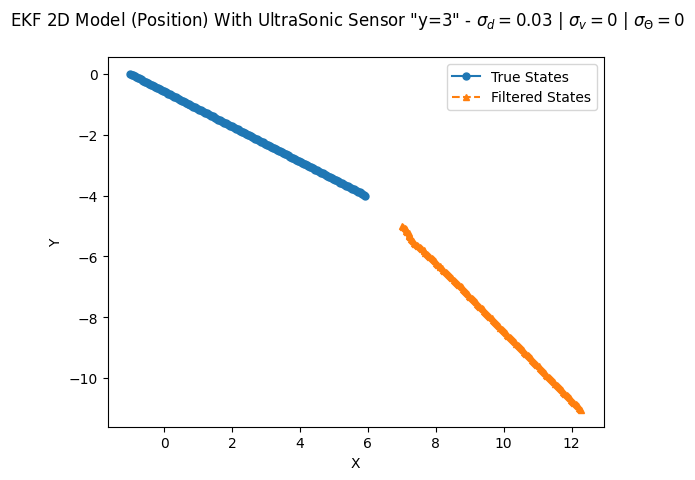

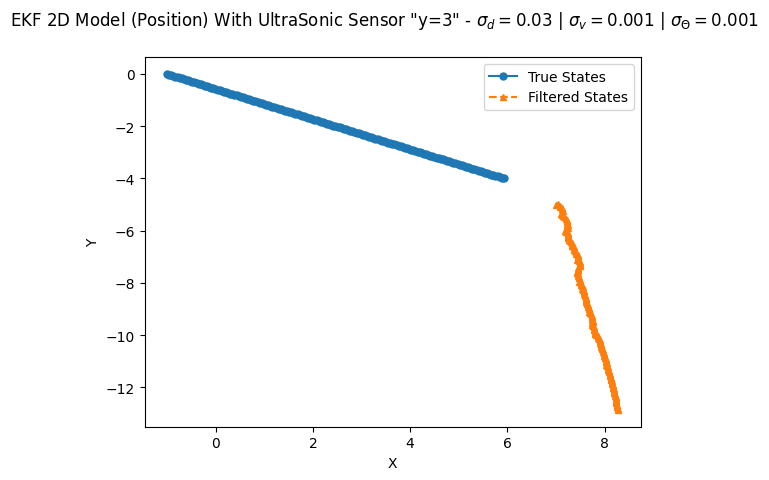

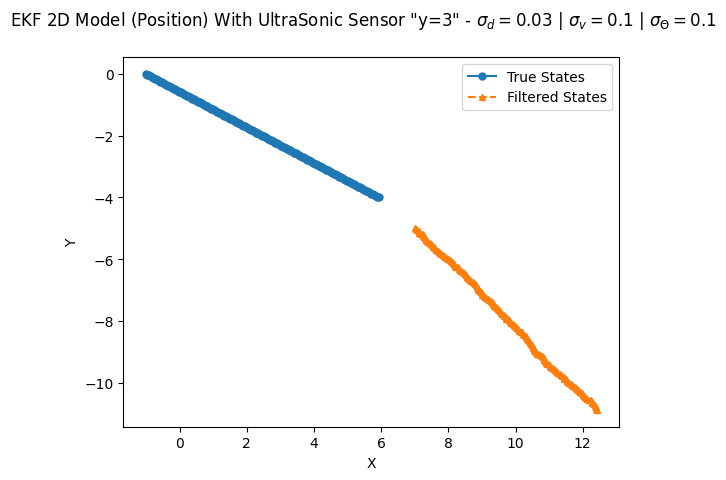

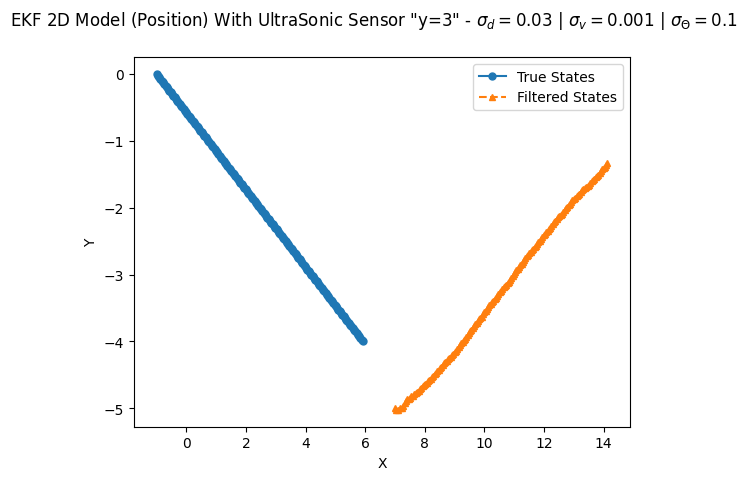

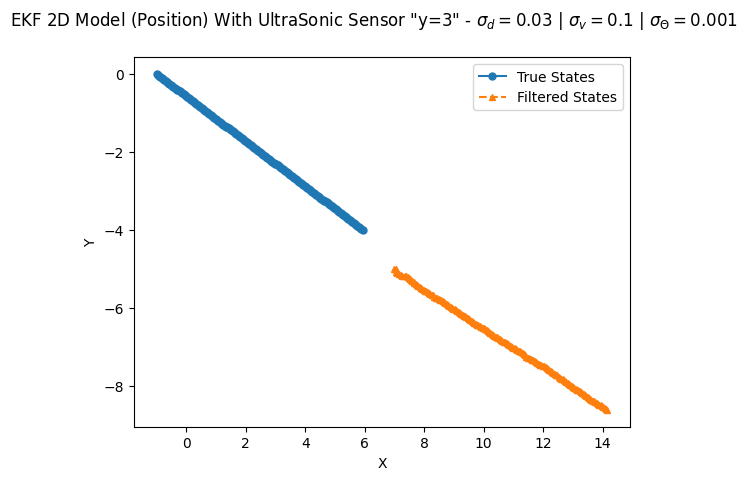

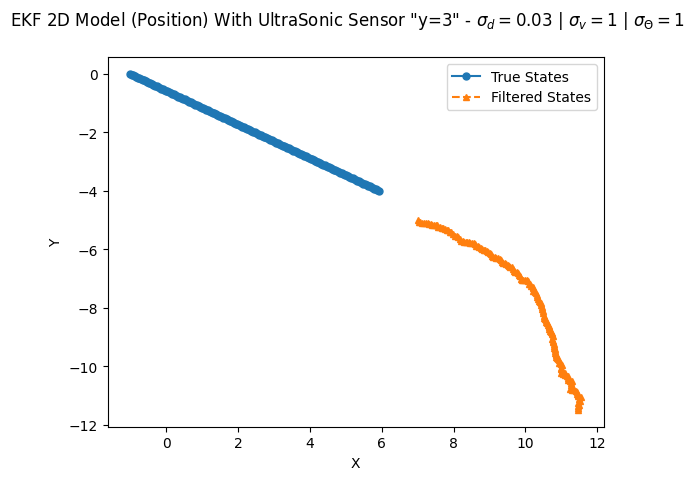

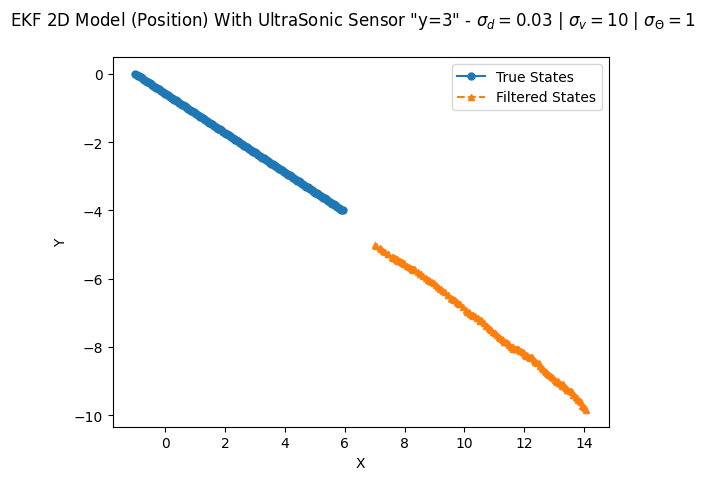

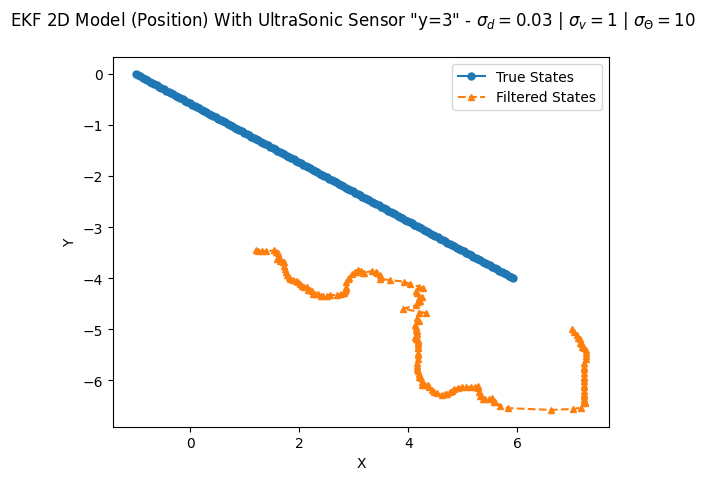

In [17]:
np.random.seed(42)
for sigma_v, sigma_theta in [(0, 0), (0.001, 0.001), (0.1, 0.1), (0.001, 0.1), (0.1, 0.001), (1, 1), (10,1), (1,10)]:
    sigmas = [sigma_d, sigma_v, sigma_theta]
    filtered_states, filtered_covariance=ekf_filter(initial_state, initial_covariance, sigmas, t_max, dt)
    filtered_states = np.array(filtered_states)
    true_trajectory = np.array(true_trajectory)
    plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic Sensor "y=3" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')

#### 1.d Ultrasonic distance sensor emitting ultrasonic waves towards two walls located at x=20 and y=3 at respective periods of 0.2 s and 0.3 s

we have two walls:
$d_1 = |x-20|$ and $d_2 = |y-3|$

$d_{y=3} = |y - 3| + v_k = \sqrt{(y-3)^2} + v_{d_k} \rightarrow H_{d_{y=3}} = \frac{\delta h_d}{\delta x_j} = \begin{bmatrix} 0 & \frac{y-3}{|y-3|} & 0  \end{bmatrix}$


$R_{d_{y=3}} = \begin{bmatrix} \sigma_d^2 \end{bmatrix} \ and \ V_d=\frac{\delta h_d}{\delta v_i}= 1$

$d_{x=20} = |x - 20| + v_k = \sqrt{(x-20)^2} + v_{d_k}
\rightarrow H_{d_{x=20}} = \frac{\delta h_d}{\delta x_j} = \begin{bmatrix} 0 & \frac{x-20}{|x-20|} & 0 & 0  \end{bmatrix}$

$R_{d_{x=20}} = \begin{bmatrix} \sigma_d^2 \end{bmatrix} \ and \ V_d=\frac{\delta h_d}{\delta v_i}= 1$


In [18]:
def ultrasonic_sensor_y(state, sigma):
    y = state[1]
    d = np.abs(y-3) + np.random.normal(0, sigma)
    return d

def ultrasonic_sensor_x(state, sigma):
    x = state[0]
    d = np.abs(x-20) + np.random.normal(0, sigma)
    return d



def get_measurement(sigmas, state, dt, elapsed_time):

    d = None
    d1, d2 = None, None
    if elapsed_time % (0.2*0.3) == 0:
        d1 = ultrasonic_sensor_x(state, sigmas[0]) # x=20
        d2 = ultrasonic_sensor_y(state, sigmas[1]) # y=3

    if elapsed_time % 0.2 == 0 and elapsed_time % (0.3) != 0:
        d = ultrasonic_sensor_x(state, sigmas[0])
    elif elapsed_time % 0.3 == 0 and elapsed_time % (0.2) != 0:
        d = ultrasonic_sensor_y(state, sigmas[0])


    if d and elapsed_time % (0.2*0.3) != 0:

        return np.array([d])
    elif d1 and d2 and elapsed_time % (0.2*0.3) == 0:

        return np.array([d1, d2])


    return np.array([0, 0])



def measurement_function(state, dt, elapsed_time):

    x, y = state[0], state[1]
    d = None
    d1, d2 = None, None
    if elapsed_time % (0.2*0.3) == 0:
        d1 = np.abs(x-20)
        d2 = np.abs(y-3)

    if elapsed_time % 0.2 == 0 and elapsed_time % (0.3) != 0:
        d = np.abs(x-20)
    elif elapsed_time % 0.3 == 0 and elapsed_time % (0.2) != 0:
        d = np.abs(y-3)


    if d and elapsed_time % (0.2*0.3) != 0:

        return np.array([d])
    elif d1 and d2 and elapsed_time % (0.2*0.3) == 0:

        return np.array([d1, d2])


    return np.array([0,0])


def get_H(state, dt, elapsed_time):

    x, y = state[0], state[1]
    d_d = None
    d1_d, d2_d = None, None
    if elapsed_time % (0.2*0.3) == 0:
        d1_d = (x-20)/np.abs(x-20)
        d2_d = (y-3)/np.abs(y-3)

    if elapsed_time % 0.2 == 0 and elapsed_time % 0.3 != 0:
        d_d = (x-20)/np.abs(x-20)
    elif elapsed_time % 0.3 == 0 and elapsed_time % 0.2 != 0:
        d_d = (y-3)/np.abs(y-3)




    if d_d and elapsed_time % (0.2*0.3) != 0:

        return np.array([
                [0, d_d, 0],
            ])
    elif d1_d and d2_d and elapsed_time % (0.2*0.3) == 0:

        return np.array([
                [d1_d, 0, 0],
                [0, d2_d, 0],
            ])

    return np.array([[0, 0, 0],[0, 0, 0]])

def get_R(sigma_d, sigma_v, sigma_theta, elapsed_time):
    if (elapsed_time % 0.2 == 0 or elapsed_time % 0.3  == 0) and elapsed_time % (0.2*0.3):

        return np.array([[sigma_d**2]])
    elif elapsed_time % (0.2*0.3) == 0:

        return np.array([[sigma_d**2, 0],
            [0, sigma_d**2]])


    return np.array([
        [sigma_d**2, 0],
        [0, sigma_d**2]
    ])

def get_V(elapsed_time):
    if (elapsed_time % 0.2 == 0 or elapsed_time % 0.3 == 0) and elapsed_time % (0.2*0.3):

        return np.eye(1)
    elif elapsed_time % (0.2*0.3) == 0:

        return np.eye(2)
    return np.eye(2)

def state_transition(state):
    x, y, theta = state[0], state[1], state[2]
    return np.array([x + v_true*np.cos(theta)*dt, y + v_true*np.sin(theta)*dt, theta])


def get_A(v, theta, dt):
    return np.array([
        [1, 0, -v*dt*np.sin(theta)],
        [0, 1, v*dt*np.cos(theta)],
        [0, 0, 1]
    ])


def get_W(theta, dt):
    return np.array([
        [np.cos(theta)*dt, 0],
        [np.sin(theta)*dt, 0],
        [0, dt]
    ])


def get_Q(sigma_v, sigma_theta):
    return np.array([
        [sigma_v**2, 0],
        [0, sigma_theta**2]
    ])

def ekf_predict(state_update, covariance_update, dt, sigma_v, sigma_theta):
    theta = state_update[2]
    A = get_A(v_true, theta, dt)
    W = get_W(theta, dt)
    Q = get_Q(sigma_v, sigma_theta)
    state_predict = state_transition(state_update)
    covariance_predict = A @ covariance_update @ A.T + W @ Q @ W.T
    return state_predict, covariance_predict

def ekf_correction(state_predict, covariance_predict, measurement, sigmas, dt, elapsed_time):
    H = get_H(state_predict, dt, elapsed_time)
    R = get_R(*sigmas, elapsed_time)
    V = get_V(elapsed_time)
    # print("Elapsed time: ", elapsed_time)
    # print("H = ", H.shape)
    # print("R = ", R.shape)
    # print("V = ", V.shape)

    # compute the Kalman gain
    k_k = covariance_predict @ H.T @ np.linalg.pinv(H @ covariance_predict @ H.T + V @ R @ V.T)

    # print("k_k = ", k_k.shape)
    # print("state_predict = ", state_predict.shape)
    # print("measurement = ", measurement.shape)
    # update state estimate with measurement z_k
    state_update = state_predict.reshape(-1,1) + k_k @ np.array(measurement - measurement_function(state_predict, dt, elapsed_time)).reshape(-1,1)

    # update the error covariance:
    covariance_update = covariance_predict - k_k @ H @ covariance_predict

    return state_update.flatten(), covariance_update

def ekf_filter(initial_state, initial_covariance, sigmas, t_max, dt):
    state = initial_state
    covariance = initial_covariance
    elapsed_time = 0
    filtered_states = [initial_state[:2]]
    filtered_covariances = []
    for _ in range(int(t_max/dt)):

        # predict the states
        state_predict, covariance_predict = ekf_predict(state, covariance, dt, sigmas[1], sigmas[2])

        # take measurements:
        measurement = get_measurement(sigmas, state_predict, dt, elapsed_time)

        state, covariance = ekf_correction(state_predict, covariance_predict, measurement, sigmas, dt, elapsed_time)
        # print(">> state", state)

        filtered_states.append(state[:2])
        filtered_covariances.append(covariance[:2, :2])
        elapsed_time += dt
        # print(">> elapsed_time", elapsed_time)
    return filtered_states, filtered_covariances

In [19]:
theta = -np.pi/6 # -30 degrees
initial_state = np.array([7,-5, theta])
initial_covariance = np.eye(3)
sigma_d = 0.03

t_max = 16
dt = 0.1


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/3632006471.py:7: SyntaxWarning: invalid escape sequence '\s'
  plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic distance Sensor "y=3; x=20" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/3632006471.py:7: SyntaxWarning: invalid escape sequence '\s'
  plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic distance Sensor "y=3; x=20" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipy

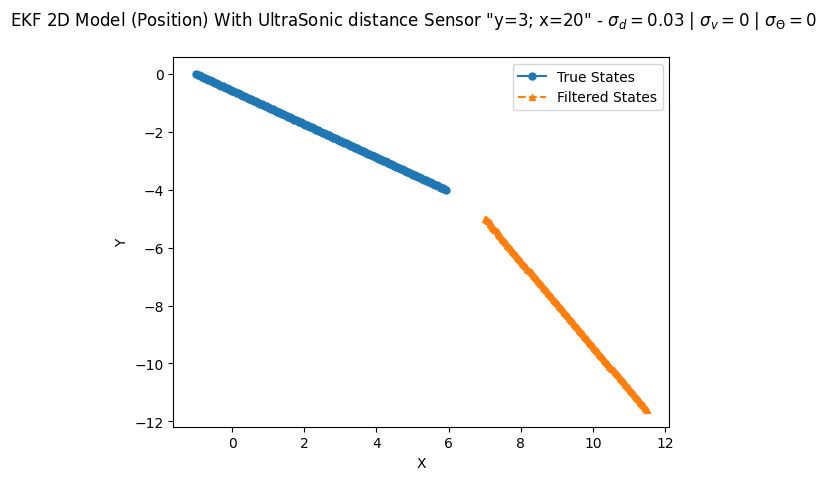

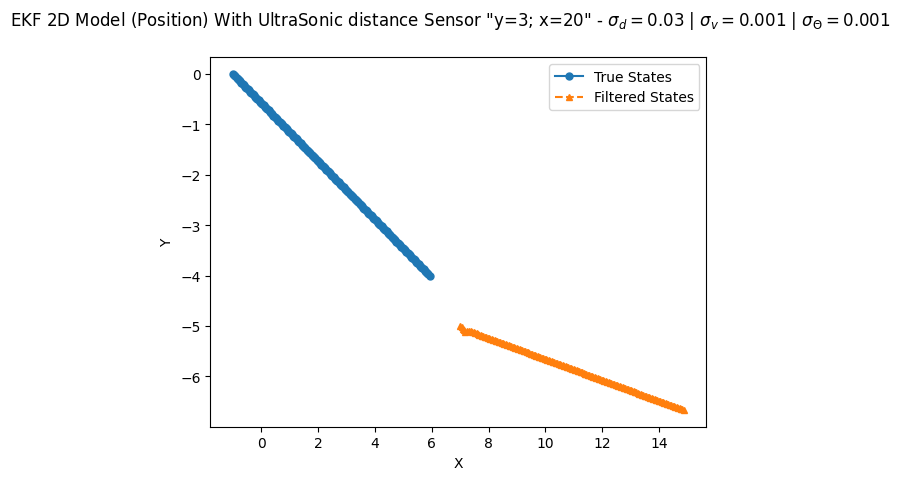

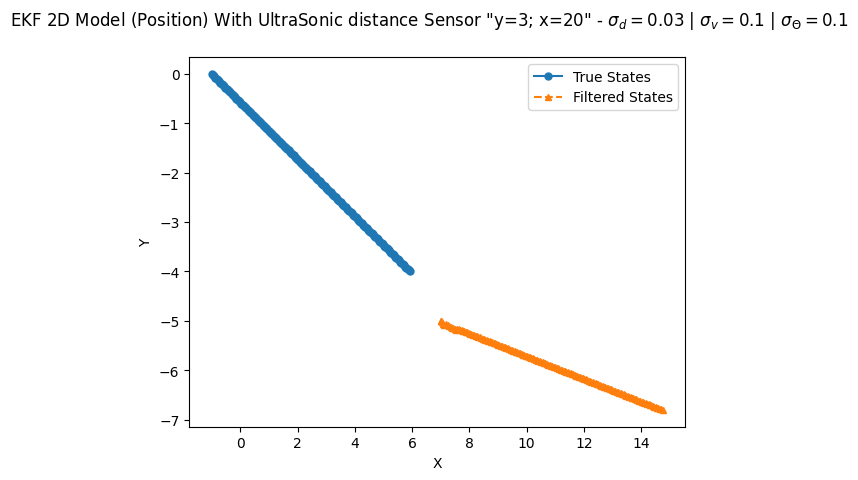

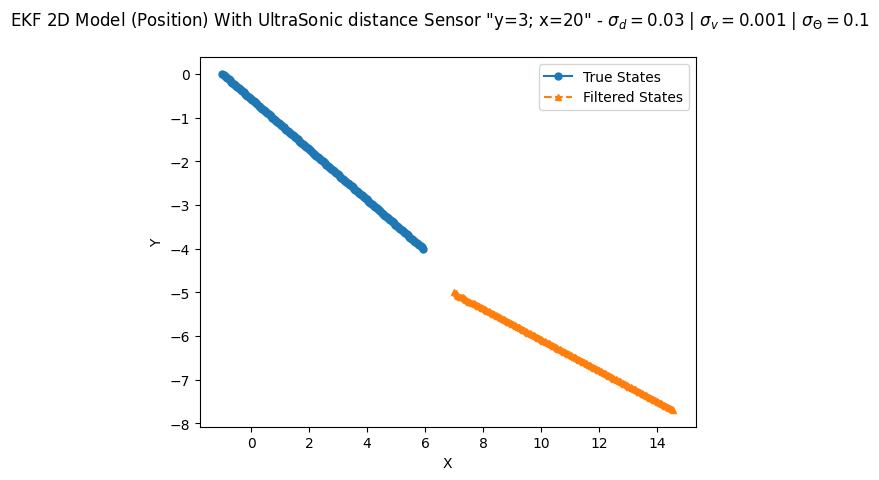

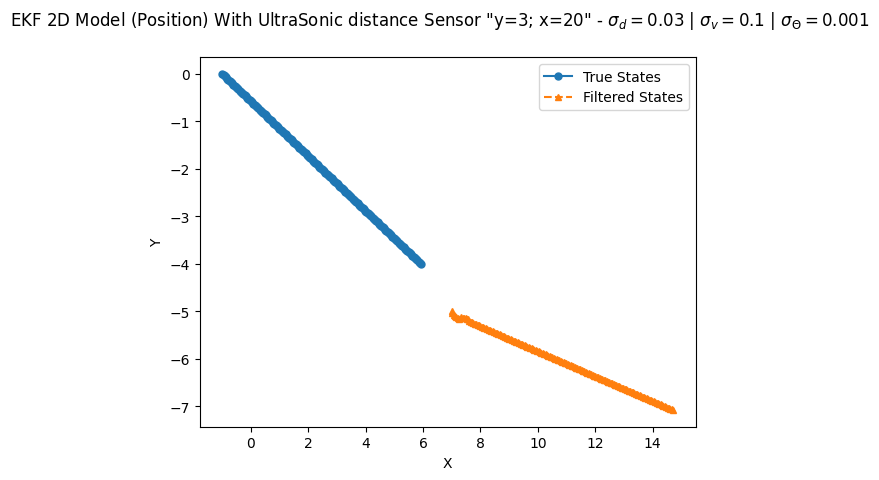

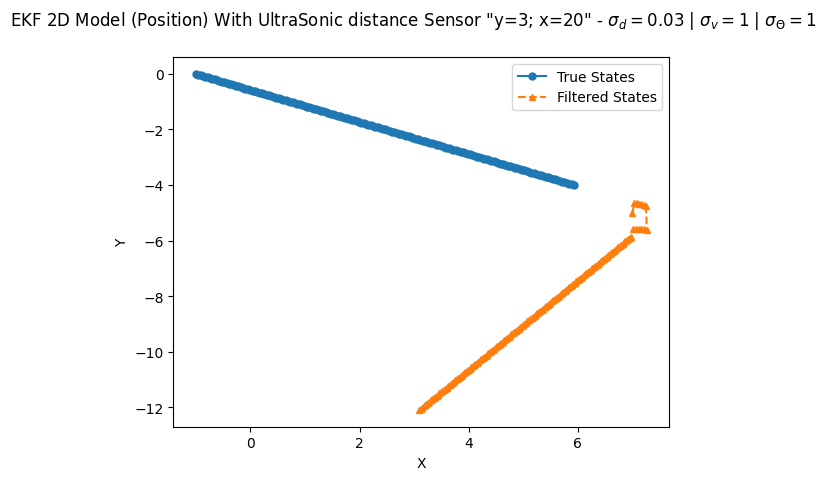

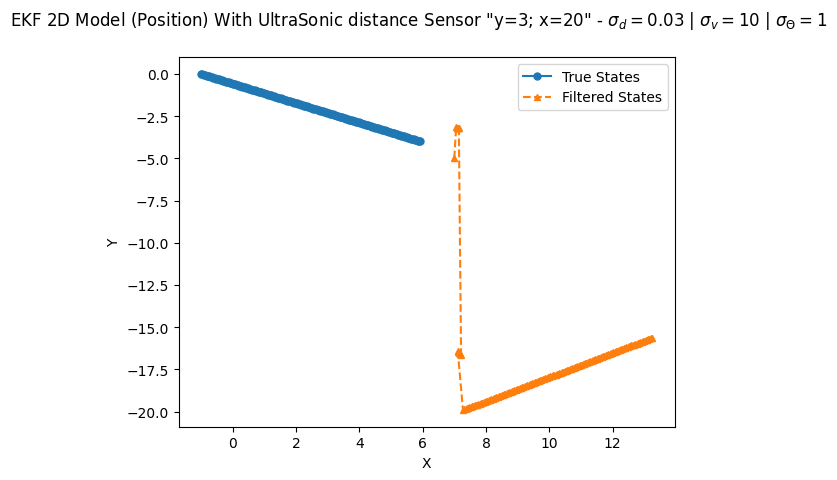

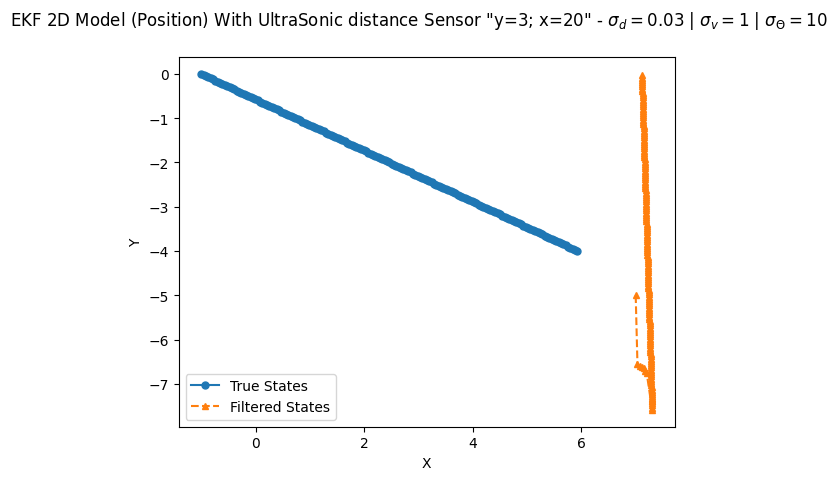

In [20]:
np.random.seed(42)
for sigma_v, sigma_theta in [(0, 0), (0.001, 0.001), (0.1, 0.1), (0.001, 0.1), (0.1, 0.001), (1, 1), (10, 1), (1, 10)]:
    sigmas = [sigma_d, sigma_v, sigma_theta]
    filtered_states, filtered_covariance=ekf_filter(initial_state, initial_covariance, sigmas, t_max, dt)
    filtered_states = np.array(filtered_states)
    true_trajectory = np.array(true_trajectory)
    plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic distance Sensor "y=3; x=20" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')

#### 1.e Ultrasonic sensor receives signal from a bacon located at x=3 and y=0. With $\sigma = 0.03$

X = [x, y, theta]

In [21]:
def ultrasonic_beacon_sensor(state, sigma):
    x, y = state[0], state[1]
    d = np.sqrt((x-3)**2 + y**2) + np.random.normal(0, sigma)
    return d

def get_measurement(sigmas, state, dt):


    d = ultrasonic_beacon_sensor(state, sigmas[0])

    return np.array([d])

def measurement_function(state, dt):

    x, y = state[0], state[1]
    d = np.sqrt((x-3)**2 + y**2)


    return np.array([d])



def get_H(state, dt):

    x, y = state[0], state[1]
    r = np.sqrt((x-3)**2 + y**2)
    d_dx = (x-3)/r
    d_dy = y/r

    return np.array([[d_dx, d_dy, 0]])

def get_R(sigma_d, sigma_v, sigma_theta):

    return np.array([[sigma_d**2]])


def get_V():

    return np.eye(1)

def get_A(v, theta, dt):
    return np.array([
        [1, 0, -v*dt*np.sin(theta)],
        [0, 1, v*dt*np.cos(theta)],
        [0, 0, 1]
    ])

def get_W(theta, dt):
    return np.array([
        [np.cos(theta)*dt, 0],
        [np.sin(theta)*dt, 0],
        [0, dt]
    ])

def get_Q(sigma_v, sigma_theta):
    return np.array([
        [sigma_v**2, 0],
        [0, sigma_theta**2]
    ])

def state_transition(state):
    x, y, theta = state[0], state[1], state[2]
    return np.array([x + v_true*np.cos(theta)*dt, y + v_true*np.sin(theta)*dt, theta])

def ekf_predict(state_update, covariance_update, dt, sigma_v, sigma_theta):
    theta = state_update[2]

    A = get_A(v_true, theta, dt)
    W = get_W(theta, dt)
    Q = get_Q(sigma_v, sigma_theta)
    state_predict = state_transition(state_update)
    covariance_predict = A @ covariance_update @ A.T + W @ Q @ W.T
    return state_predict, covariance_predict

def ekf_correction(state_predict, covariance_predict, measurement, sigmas, dt, elapsed_time):
    H = get_H(state_predict, dt)
    R = get_R(*sigmas)
    V = get_V()
    # print("H = ", H.shape)
    # print("R = ", R.shape)
    # print("V = ", V.shape)

    # compute the Kalman gain
    k_k = covariance_predict @ H.T @ np.linalg.pinv(H @ covariance_predict @ H.T + V @ R @ V.T)

    # update state estimate with measurement z_k
    state_update = state_predict.reshape(-1,1) + k_k @ np.array(measurement - measurement_function(state_predict, dt)).reshape(-1,1)

    # update the error covariance:
    covariance_update = covariance_predict - k_k @ H @ covariance_predict

    return state_update.flatten(), covariance_update

def ekf_filter(initial_state, initial_covariance, sigmas, t_max, dt):
    state = initial_state
    covariance = initial_covariance
    elapsed_time = 0
    filtered_states = []
    filtered_covariances = []
    for _ in range(int(t_max/dt)):

        # predict the states
        state_predict, covariance_predict = ekf_predict(state, covariance, dt, sigmas[1], sigmas[2])
        # take measurements:
        measurement = get_measurement(sigmas, state_predict, dt)

        state, covariance = ekf_correction(state_predict, covariance_predict, measurement, sigmas, dt, elapsed_time)
        # print(">> state", state)

        filtered_states.append(state[:2])
        filtered_covariances.append(covariance[:2, :2])
        elapsed_time += dt
        # print(">> elapsed_time", elapsed_time)
    return filtered_states, filtered_covariances

In [22]:
theta = -np.pi/6 # -30 degrees
initial_state = np.array([-0.5,-1,theta])
initial_covariance = np.eye(3)
sigma_d = 0.03

t_max = 16
dt = 0.1


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/1679777764.py:7: SyntaxWarning: invalid escape sequence '\s'
  plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic distance Sensor to bacon "x=3; y=0" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')
/var/folders/51/gkw58slj4gq47xhbrz7hl1j40000gn/T/ipykernel_45293/1679777764.py:7: SyntaxWarning: invalid escape sequence '\s'
  plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic distance Sensor to bacon "x=3; y=0" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')
/var/folders/51/gkw58slj4gq47xhbrz7h

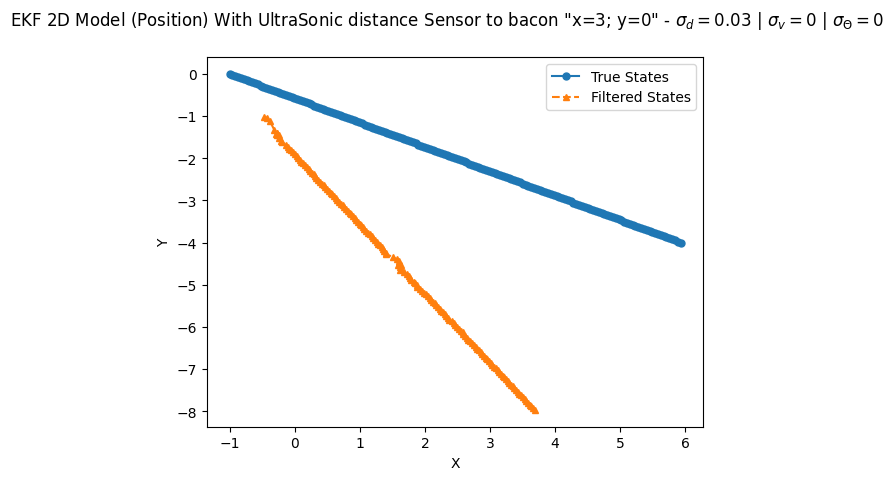

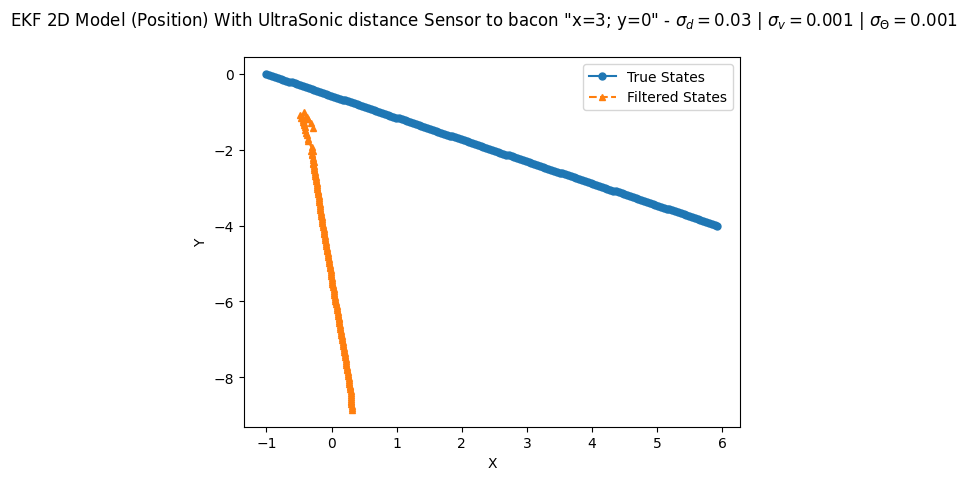

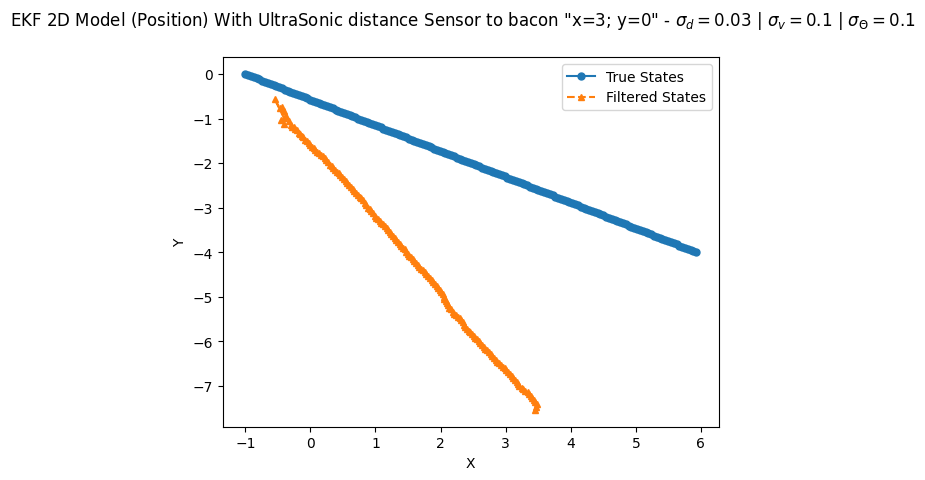

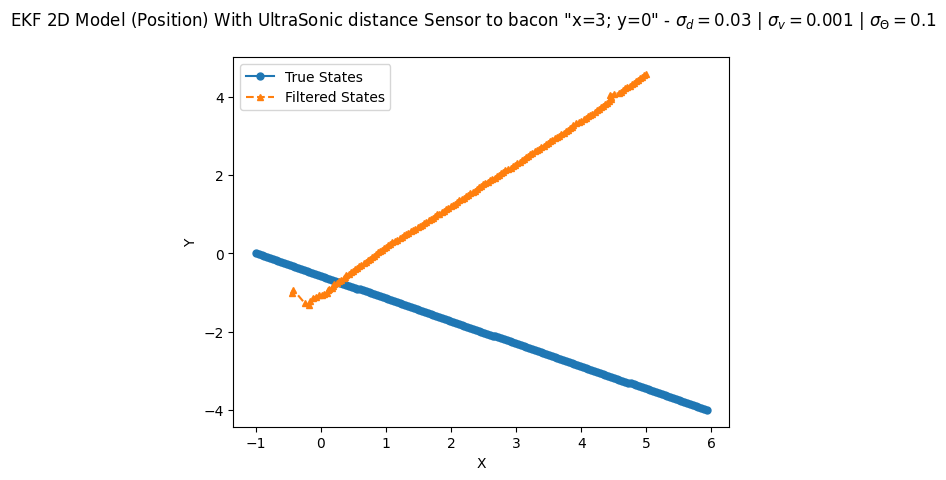

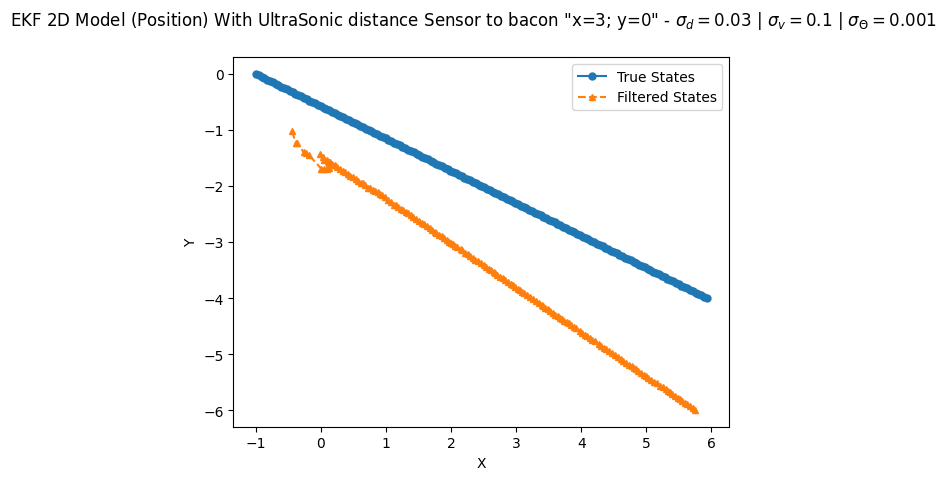

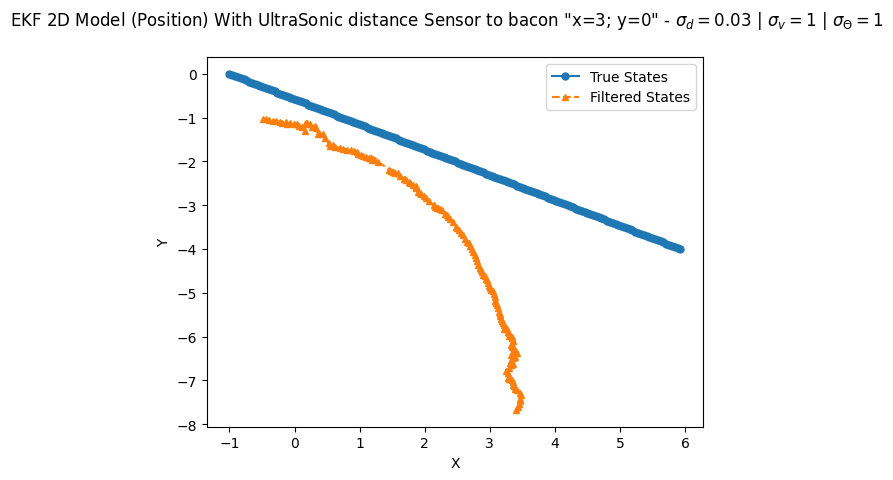

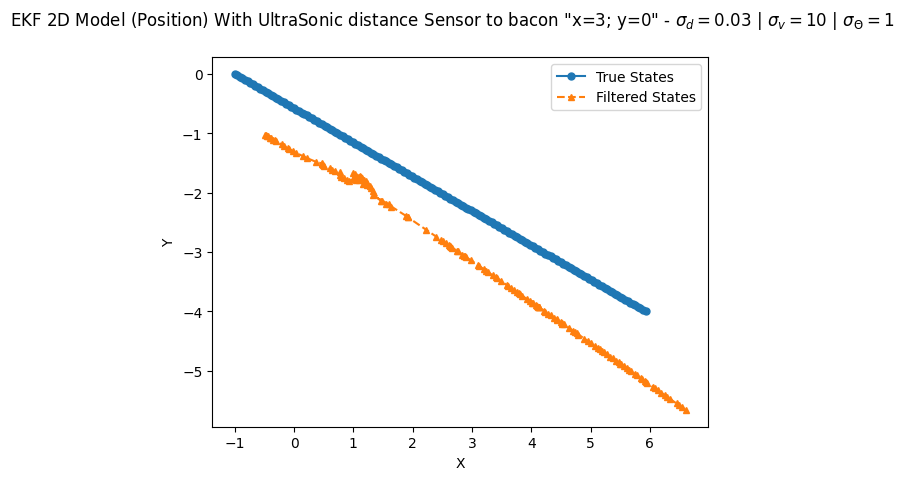

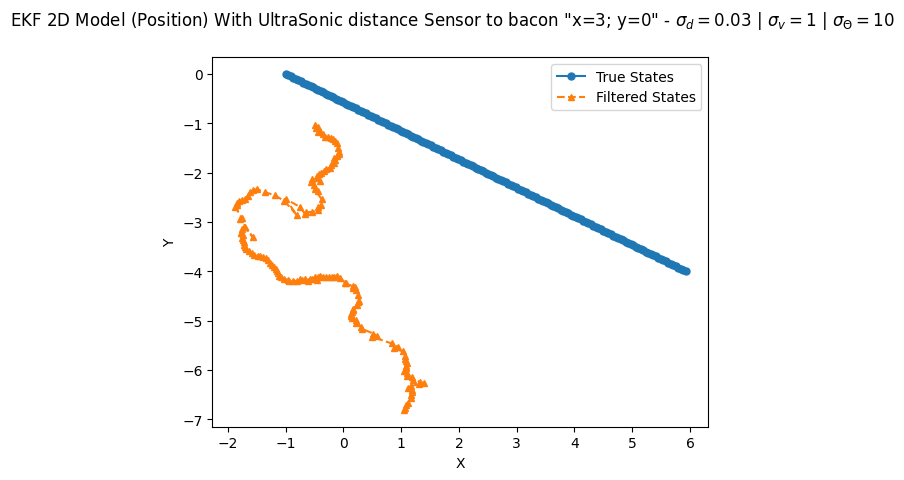

In [23]:
np.random.seed(42)
for sigma_v, sigma_theta in [(0, 0), (0.001, 0.001), (0.1, 0.1), (0.001, 0.1), (0.1, 0.001), (1, 1), (10, 1), (1, 10)]:
    sigmas = [sigma_d, sigma_v, sigma_theta]
    filtered_states, filtered_covariance=ekf_filter(initial_state, initial_covariance, sigmas, t_max, dt)
    filtered_states = np.array(filtered_states)
    true_trajectory = np.array(true_trajectory)
    plot_result(true_trajectory, filtered_states, f'EKF 2D Model (Position) With UltraSonic distance Sensor to bacon "x=3; y=0" - $\sigma_d={sigma_d}$ | $\sigma_v={sigma_v}$ | $\sigma_\Theta={sigma_theta}$')

2. Distributed Sensor Fusion for Object Position Estimation by Multi-Robot Systems
$C_g = R^T (-\theta) C_l R(-\theta)$

$R = \begin{bmatrix} \cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta)  \end{bmatrix}$


$C = C_1 - C_1 [C_1+C_2]^{-1} C_1 $

$\hat{X} = \hat{X}_1 + C_1 [C_1+C_2]^{-1}(\hat{X}_2-\hat{X}_1)$

In [24]:
def rotate_matrix(M, theta):
    theta = np.radians(theta)
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    return R @ M @ R.T

def merge_gaussian(X1, M1, X2, M2):
    C_inv = np.linalg.inv(M1 + M2)

    C = M1 - M1@C_inv@M1
    X = X1 + M1@C_inv@(X2-X1)

    return X, C

def extract_params(C):
    a, b, c = C[0, 0], C[0, 1], C[1, 1]
    theta = 0.5 * np.arctan(2 * b/(a - c))
    # rotate the covariance matrix to align with the major and minor axes
    C_rot = rotate_matrix(C, -theta)
    return theta, C_rot


In [25]:
import numpy as np
X1 = np.array([12.34, 9.02])
M1 = np.array([[25, 0],
               [0, 9]])
theta1 = 30
X2 = np.array([9.90, 11.69])
M2 = np.array([[9, 0],
               [0, 1]])
theta2 = 60
def fuse_2(X1, X2, M1, M2, theta1, theta2):
    # rotate matrices to global coordinates frame:
    C1 = rotate_matrix(M1, -theta1)
    C2 = rotate_matrix(M2, -theta2)
    # merge the observation with kalman filter:
    Xm, Cm = merge_gaussian(X1, C1, X2, C2)
    # extract params:
    theta_ext, C_local = extract_params(Cm)
    return Xm, Cm, C_local, theta_ext

def fuse_3(Xs, Ms, thetas):
    Cs = [rotate_matrix(M, -th) for M, th in zip(Ms, thetas)]
    X1, C1 = merge_gaussian(Xs[0], Cs[0], Xs[1], Cs[1])
    X2, C2 = merge_gaussian(X1, C1, Xs[2], Cs[2])

    # extract params:
    theta, C = extract_params(C2)
    return X2, C, theta

# rotate matrices to global coordinates frame:
C1 = rotate_matrix(M1, -theta1)
C2 = rotate_matrix(M2, -theta2)

# merge the observation with kalman filter:
Xm, Cm = merge_gaussian(X1, C1, X2, C2)

# extract params:
theta_ext, C_local = extract_params(Cm)

print("The merged mean is: ", Xm)

The merged mean is:  [10.430369   10.76530217]


In [26]:
print("The merge angle is:", np.degrees(theta_ext))
print("The merge major and minor axis standard deviations:", (np.sqrt(C_local[0,0]), np.sqrt(C_local[1,1])))

The merge angle is: 31.905630524732228
The merge major and minor axis standard deviations: (1.5095722944188303, 2.1429323904077227)


## **Note: 
    ** The merged mean is closer to the true position of the target (10,10) than the individual means
    ** The merged standard deviations are relatively smaller than the individual standard deviations except for the minor axis standard deviation of the observations from robot 2 which is lower.
    ** The merge angle is consistent with the observation angle of robot 1. This is explained by the larger deviation along the major axis, hence more information in that direction. 


#### 2.c set a scenario where a target moves, randomly specify positions of three or more robots, and observe the target (observation accuracy of each sensor system can be set as needed). Achieve fusion of target position (similar to the generalized case in Figure 8 in the paper)

In [27]:
M1 = np.array([[0.25, 0], [0, 0.09]])
X1 = np.array([-5, 0])
M2 = np.array([[0.09, 0], [0, 0.01]])
X2 = np.array([0, -6])
M3 = np.array([[0.04, 0], [0, 0.09]])
X3 = np.array([6, 0])

In [28]:
np.random.multivariate_normal(mean=np.array([-4,1]), cov=M1)

array([-3.93322955,  0.95425905])

In [29]:
np.diag(M1)

array([0.25, 0.09])

In [30]:
np.random.normal(loc=np.array([-4,1]), scale=np.sqrt(np.diag(M1)))

array([-3.64594566,  1.2870107 ])

In [31]:
np.random.seed(7)
true_positions_lst = [[-4, 1], [-4, 0], [-3, 0], [-2, 0], [-1, -1], [0,-2], [0, -3], [1, -4], [2, -5]]

true_xy = [np.array(p) for p in true_positions_lst]
r1_measurements = [np.random.multivariate_normal(mean=p, cov=M1) for p in true_xy]
r2_measurements = [np.random.multivariate_normal(mean=p, cov=M2) for p in true_xy]
r3_measurements = [np.random.multivariate_normal(mean=p, cov=M3) for p in true_xy]


In [32]:
r1_measurements

[array([-3.15473715,  0.86021879]),
 array([-3.98358992,  0.12225488]),
 array([-3.39446151e+00,  6.19671872e-04]),
 array([-2.00044519, -0.52641729]),
 array([-0.491171  , -0.81985045]),
 array([-0.31271449, -2.05146448]),
 array([ 0.25264969, -3.07840692]),
 array([ 0.87862546, -4.43597242]),
 array([ 2.27729016, -4.96283573])]

In [33]:
r2_measurements

[array([-3.91766202,  0.84734755]),
 array([-3.50479009,  0.01543355]),
 array([-3.11614198,  0.20290722]),
 array([-2.01361581, -0.14506787]),
 array([-1.12156836, -1.22883151]),
 array([ 0.31481896, -2.04164743]),
 array([-0.22276606, -2.89275299]),
 array([ 0.50467732, -3.94645706]),
 array([ 1.38067556, -5.06621593])]

In [34]:
r3_measurements

[array([-3.70760487,  0.63873405]),
 array([-4.06588275,  0.52984826]),
 array([-3.03599728,  0.25221997]),
 array([-2.15056744,  0.17041857]),
 array([-1.36061973, -1.51250176]),
 array([ 0.44951901, -1.88506344]),
 array([-0.10492092, -2.91917651]),
 array([ 1.04746037, -3.42639434]),
 array([ 2.05051555, -4.9695698 ])]

In [35]:
def thetas(t, r):
    dy = t[1]-r[1]
    dx = t[0]-r[0]
    return np.degrees(np.arctan(dy/dx))

thetas1 = [thetas(t, X1) for t in r1_measurements]
thetas2 = [thetas(t, X2) for t in r2_measurements]
thetas3 = [thetas(t, X3) for t in r3_measurements]

In [37]:
[(x1, x2, x3, theta1, theta2, theta3) for x1, x2, x3, theta1, theta2, theta3 in zip(r1_measurements, r2_measurements, r3_measurements, thetas1, thetas2, thetas3)][0]

(array([-3.15473715,  0.86021879]),
 array([-3.91766202,  0.84734755]),
 array([-3.70760487,  0.63873405]),
 24.993842656311376,
 -60.22427010659305,
 -3.764480501435631)

In [38]:
predicted_traj = []
predicted_cov = []
theta_ms = []
for x1, x2, x3, theta1, theta2, theta3 in zip(r1_measurements, r2_measurements, r3_measurements, thetas1, thetas2, thetas3):

    Xm, C, theta = fuse_3([x1, x2, x3], [M1, M2, M3], [theta1, theta2, theta3])
    predicted_traj.append(Xm)
    predicted_cov.append(C)
    theta_ms.append(theta)
    # print(Xm, C_local3, theta_m)

In [39]:
np.array(predicted_traj)

array([[-3.81135262,  0.91677079],
       [-3.6446343 ,  0.0317716 ],
       [-3.11890927,  0.16844351],
       [-2.04610476, -0.18322155],
       [-1.14251097, -1.21560277],
       [ 0.30931073, -1.955724  ],
       [-0.18716411, -2.99897259],
       [ 0.60630723, -3.9948552 ],
       [ 1.709161  , -5.21463516]])

In [40]:
true_xy

[array([-4,  1]),
 array([-4,  0]),
 array([-3,  0]),
 array([-2,  0]),
 array([-1, -1]),
 array([ 0, -2]),
 array([ 0, -3]),
 array([ 1, -4]),
 array([ 2, -5])]

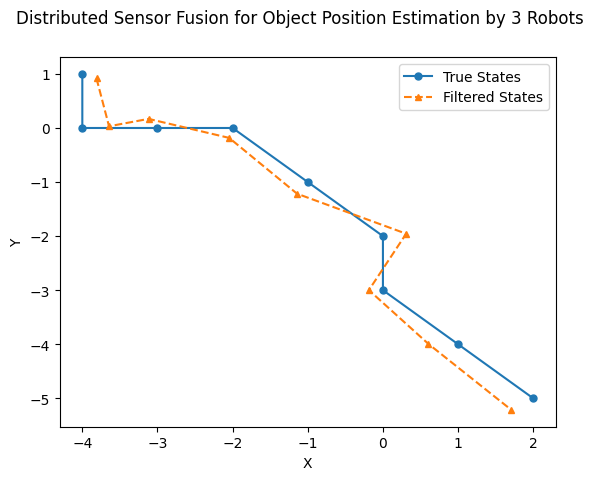

In [41]:
plot_result(np.array(true_xy), np.array(predicted_traj), 'Distributed Sensor Fusion for Object Position Estimation by 3 Robots')

#### 3.a. Integration f(x) = cos(x)
$I = \int^{\pi/2}_{0} cos(x) dx$, 
Assume $h=(\pi/2 - 0)/n$ with n=10,100,1000,10000,30000

In [42]:
def f(x):
    return np.cos(x)

af = 0.0
bf = np.pi/2
nf = 100
tf = 1.0

#### 3.b $f(x, y) = x^2+6xy+y^2$

$I = \underset{x^2+y^2 \leq 1}{\int \int} f(x) dxdy$ 

h = 0.5, 0.1, 0.05, 0.025, 0.01

In [43]:
def g(x,y):
    return x**2 + 6*x*y + y**2

agx = -1
bgx = 1
agy = -1
bgy = 1
ng = 100
tg = 8/3

In [44]:
# numerical integration methods:

# rectangular formula algorithm:
def rectangular_formula(f, a, b, n):
    h = (b-a)/n
    approx = sum(f(a + i*h)*h for i in range(n+1))
    return approx

def double_rectangular_formula(f, ax, bx, ay, by, n):
    hx = (bx-ax)/n
    hy = (by-ay)/n
    approx = 0
    for i in range(n+1):
        for j in range(n+1):
            approx += hx*hy*f(ax+i*hx, ay+j*hy)

    return approx

# trapezoidal formula algorithm
def trapezoidal_formula(f, a, b, n):
    h = (b-a)/n
    approx = f(a)+f(b)
    for i in range(1, n):
        approx += 2 * f(a+i*h)

    approx *= h/2
    return approx

def double_trapezoidal_formula(f, ax, bx, ay, by, n):
    hx = (bx-ax)/n
    hy = (by-ay)/n
    approx = 0.0
    for i in range(n):
        for j in range(n):
            xi = ax+i*hx
            yj = ay+j*hy

            approx += (f(xi,yj) + f(xi,yj+hy) + f(xi+hx,yj) + f(xi+hx,yj+hy))
    approx *= (hx/2)*(hy/2)
    return approx

# Simpson's formula algorithm:
def simpson_formula(f, a, b, n):
    h = (b-a)/n
    approx = f(a)+f(b)
    for i in range(1, n):
        coef = 4 if i%2==1 else 2
        approx += coef*f(a+i*h)
    approx *= h/3
    return approx

def double_simpson_formula(f, ax, bx, ay, by, n):
    hx = (bx-ax)/n
    hy = (by-ay)/n
    approx = 0.0
    for i in range(n):
        for j in range(n):
            xi = ax+i*hx
            yj = ay+j*hy
            coefx = 4 if i % 2 == 1 else 2
            coefy = 4 if j % 2 == 1 else 2
            approx += coefx * coefy * f(xi, yj)
    approx *= (hx*hy)/9
    return approx

def err(truth, approx):
    return np.abs(truth-approx)

In [45]:
f_hat = rectangular_formula(f, af, bf, nf)
f_err = err(tf, f_hat)
f_hat, f_err

(1.007833419873582, 0.007833419873582104)

In [46]:
trapezoidal_formula(f, af, bf, nf)

0.9999794382396076

In [47]:
simpson_formula(f, af, bf, nf)

1.0000000003382365

In [48]:
double_rectangular_formula(g, agx, bgx, agy, bgy, ng)

2.774671999999992

In [49]:
double_trapezoidal_formula(g, agx, bgx, agy, bgy, ng)

2.667200000000009

In [ ]:
double_simpson_formula(g, agx, bgx, agy, bgy, ng)

#### error with respect to the step sizes


In [50]:
n_pts = [10,100,1000,10000,30000]
hs = [(bf-af)/n for n in n_pts]
rect_err = []
trapez_err = []
simps_err = []
for n in n_pts:
    rect_err.append(err(tf,rectangular_formula(f,af,bf,n)))
    trapez_err.append(err(tf, trapezoidal_formula(f, af, bf, n)))
    simps_err.append(err(tf, simpson_formula(f,af,bf,n)))


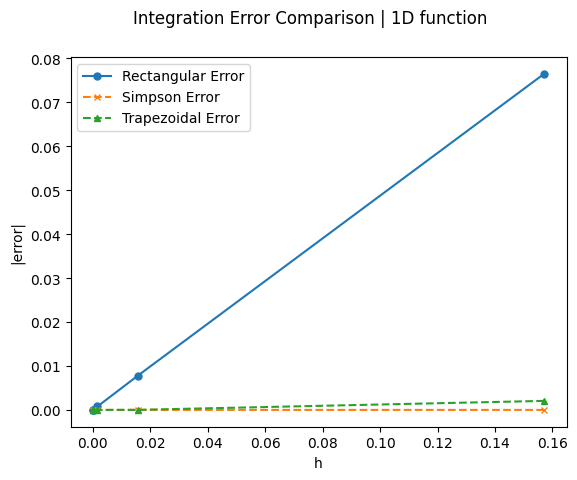

In [51]:
plt.plot(hs, rect_err, label='Rectangular Error', marker='o', markersize=5)
plt.plot(hs, simps_err, label='Simpson Error', linestyle='--', marker='x', markersize=5)
plt.plot(hs, trapez_err, label='Trapezoidal Error', linestyle='--', marker='^', markersize=5)
plt.suptitle("Integration Error Comparison | 1D function")
plt.xlabel('h')
plt.ylabel('|error|')
plt.legend()
plt.show()

2D integration

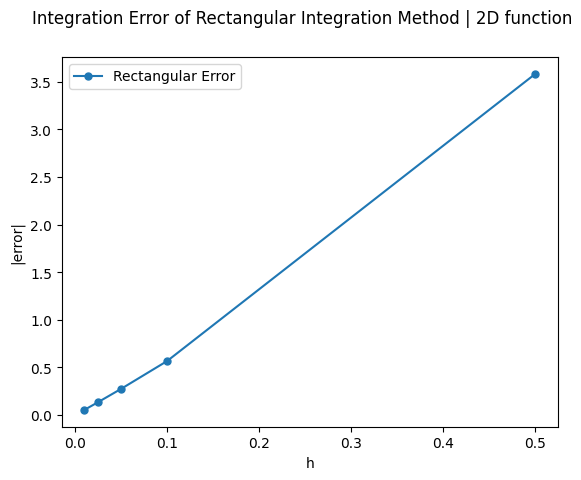

In [52]:
ng = [4, 20, 40, 80, 200]
hgs = [(bgx-agx)/n for n in ng]
rect_err_g = []
rect_err_f = []
for n in ng:
    rect_err_g.append(err(tg, double_rectangular_formula(g, agx, bgx, agy, bgy, n)))
    rect_err_f.append(err(tf, rectangular_formula(f, af, bf, n)))

plt.plot(hgs, rect_err_g, label='Rectangular Error', marker='o', markersize=5)
plt.suptitle("Integration Error of Rectangular Integration Method | 2D function")
plt.xlabel('h')
plt.ylabel('|error|')
plt.legend()
plt.show()

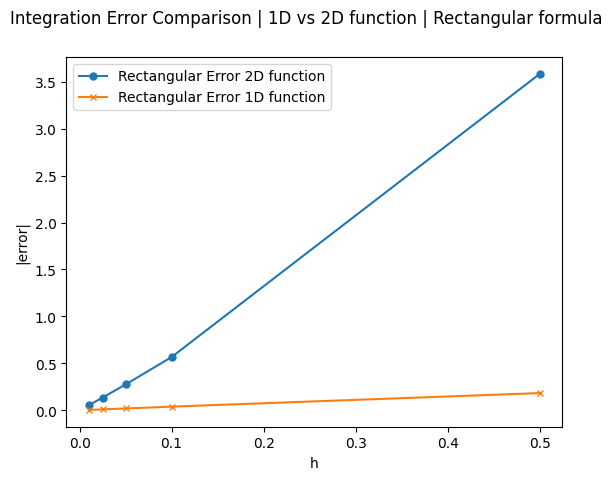

In [53]:
plt.plot(hgs, rect_err_g, label='Rectangular Error 2D function', marker='o', markersize=5)
plt.plot(hgs, rect_err_f, label='Rectangular Error 1D function', marker='x', markersize=5)
plt.suptitle("Integration Error Comparison | 1D vs 2D function | Rectangular formula")
plt.xlabel('h')
plt.ylabel('|error|')
plt.legend()
plt.show()